#### This notebook compares the CESM 0.1º and 1º O$_2$ distributions and zonal velcoity fields to observations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings

import xarray as xr
import numpy as np

import pop_tools 
from pop_tools import get_grid

from tqdm import tqdm
import bokeh

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from cartopy import util
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import proplot

from utils import *

## Read 0.1º CESM Outputs

In [4]:
path = f'/glade/scratch/yeddebba/Mesoscale/HR/CLM/'
file = f'{path}/*TPAC_CLM.nc'
dsu = xr.open_mfdataset(file, decode_times=False, decode_coords=False, data_vars=['UVEL','VVEL','O2','ULAT','ULONG','TLAT','TLONG','z_t'])
dsu

path = f'/glade/scratch/yeddebba/Mesoscale/LR/CLM/'
file = f'{path}/*.CLM.nc'
dsl = xr.open_mfdataset(file, decode_times=False, decode_coords=False, data_vars=['UVEL','VVEL','O2','ULAT','ULONG','TLAT','TLONG','z_t'])
dsl

# path = f'/glade/scratch/yeddebba/TPOSE/'
# file = f'{path}/tpose_[UV]VEL_monthly_2010to2017.nc'
# dst = xr.open_mfdataset(file, decode_times=False, decode_coords=False)
# dst

path = f'/glade/work/yeddebba/BTPOSE/www.ecco.ucsd.edu/DATA/TROPAC/bgc'
file = f'{path}/tpose_201[01234567]_[UV]VEL.nc'
dst = xr.open_mfdataset(file, decode_times=False, decode_coords=False)
dst

path = f'/glade/work/yeddebba/BTPOSE/www.ecco.ucsd.edu/DATA/TROPAC/bgc'
file = f'{path}/tpose_201[01234567]_O2.nc'
dsto = xr.open_mfdataset(file, decode_times=False, decode_coords=False)
dsto

path = f'/glade/work/yeddebba/drifter/drifter_annualmeans.nc'
dd = xr.open_mfdataset({path})
dd

path='/glade/scratch/yeddebba/Mesoscale/OBS/johnson_velocities.cdf'
dj = xr.open_dataset(path, decode_times=False, decode_coords=False)
dj

# Unit Conversion
umol_kg_mmol_m3=1*1.027
ml_l_mmol_m3=44.4

# WOA O2 data from https://www.nodc.noaa.gov/OC5/indprod.html: 
path='/glade/scratch/yeddebba/Mesoscale/OBS'
file = f'{path}/WOA2018_O2_clm.nc'
dsw = xr.open_dataset(file, decode_times=False, decode_coords=False)
varname=['o_an','lat','lon','depth'] 
dsw=dsw.drop([v for v in dsw.variables if v not in varname])
dsw=dsw*umol_kg_mmol_m3
dsw

# Using CARS CSIRO Atlas from: http://www.marine.csiro.au/~dunn/cars2009/ 
path='/glade/scratch/yeddebba/Mesoscale/OBS'  
file = f'{path}/oxygen_cars2009.nc'
dsc = xr.open_dataset(file, decode_times=False, decode_coords=False)
varname=['o2','lat','lon','depth'] 
dsc=dsc.drop([v for v in dsc.variables if v not in varname])  
dsc=dsc*ml_l_mmol_m3
dsc

In [6]:
dst

<xarray.Dataset>
Dimensions:    (XC: 1128, XG: 1128, YC: 240, YG: 240, Z: 51, time: 96)
Coordinates:
  * XG         (XG) float32 104.0 104.2 104.3 104.5 ... 291.3 291.5 291.7 291.8
  * YC         (YC) float32 -19.92 -19.75 -19.58 -19.42 ... 19.58 19.75 19.92
  * Z          (Z) float32 -2.5 -7.5 -12.5 ... -4.725e+03 -5.235e+03 -5.745e+03
  * time       (time) int64 191844000 194472000 ... 438876000 441504000
  * XC         (XC) float32 104.1 104.2 104.4 104.6 ... 291.4 291.6 291.8 291.9
  * YG         (YG) float32 -20.0 -19.83 -19.67 -19.5 ... 19.33 19.5 19.67 19.83
Data variables: (12/19)
    dyG        (time, YC, XG) float32 dask.array<chunksize=(12, 240, 1128), meta=np.ndarray>
    dxC        (time, YC, XG) float32 dask.array<chunksize=(12, 240, 1128), meta=np.ndarray>
    rAw        (time, YC, XG) float32 dask.array<chunksize=(12, 240, 1128), meta=np.ndarray>
    maskInW    (time, YC, XG) bool dask.array<chunksize=(12, 240, 1128), meta=np.ndarray>
    hFacW      (time, Z, YC, XG) float32 dask.array<chunksize=(12, 51, 240, 1128), meta=np.ndarray>
    maskW      (time, Z, YC, XG) bool dask.array<chunksize=(12, 51, 240, 1128), meta=np.ndarray>
    ...         ...
    rAs        (time, YG, XC) float32 dask.array<chunksize=(12, 240, 1128), meta=np.ndarray>
    maskInS    (time, YG, XC) bool dask.array<chunksize=(12, 240, 1128), meta=np.ndarray>
    hFacS      (time, Z, YG, XC) float32 dask.array<chunksize=(12, 51, 240, 1128), meta=np.ndarray>
    maskS      (time, Z, YG, XC) bool dask.array<chunksize=(12, 51, 240, 1128), meta=np.ndarray>
    maskCtrlS  (time, Z, YG, XC) bool dask.array<chunksize=(12, 51, 240, 1128), meta=np.ndarray>
    VVEL       (time, Z, YG, XC) float32 dask.array<chunksize=(12, 51, 240, 1128), meta=np.ndarray>

### Pick longitude Index to plot 

In [8]:
lon_ind=[110.0, 125.0, 140]
lon_w=lon_ind[1]

lat_eq=0.0
latu_i,lonu_i=find_indices(dsu.TLONG,dsu.TLAT,360-lon_w,lat_eq)
latl_i,lonl_i=find_indices(dsl.TLONG,dsl.TLAT,360-lon_w,lat_eq)
lon_joh=360.00-lon_w
lon_cars=360.00-lon_w     
z=dsu.z_t*1e-2
zl=dsl.z_t*1e-2
zj=dj.ZDEP1_50
# zt=dst.depth*(-1)
zto=dst.Z*(-1)
zto=dsto.Z*(-1)
latu=dsu.ULAT[:,lonu_i]
latl=dsl.ULAT[:,lonl_i]
latj=dj.YLAT11_101
# latt=dst.lat
latt=dst.YC
latto=dsto.YC

# U_h=dsu.UVEL.isel(nlon=lonu_i)
# U_l=dsl.UVEL.isel(nlon=lonl_i)
# U_j=dj.UM.sel(XLON=lon_joh,method='nearest')*100
# U_t=dst.UVEL.where(dst.lon==360-lon_w+0.5,drop=True).compute()
# U_d=(dd.U.where(dd.Lon==-lon_w+0.375,drop=True).squeeze()).compute()

# # O2_h=dsu.O2.isel(nlon=lonu_i)
# # O2_l=dsl.O2.isel(nlon=lonl_i)
# # O2_t=dsto.TRAC03.sel(XC=360-lon_w,method='nearest').mean('time').compute()



100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


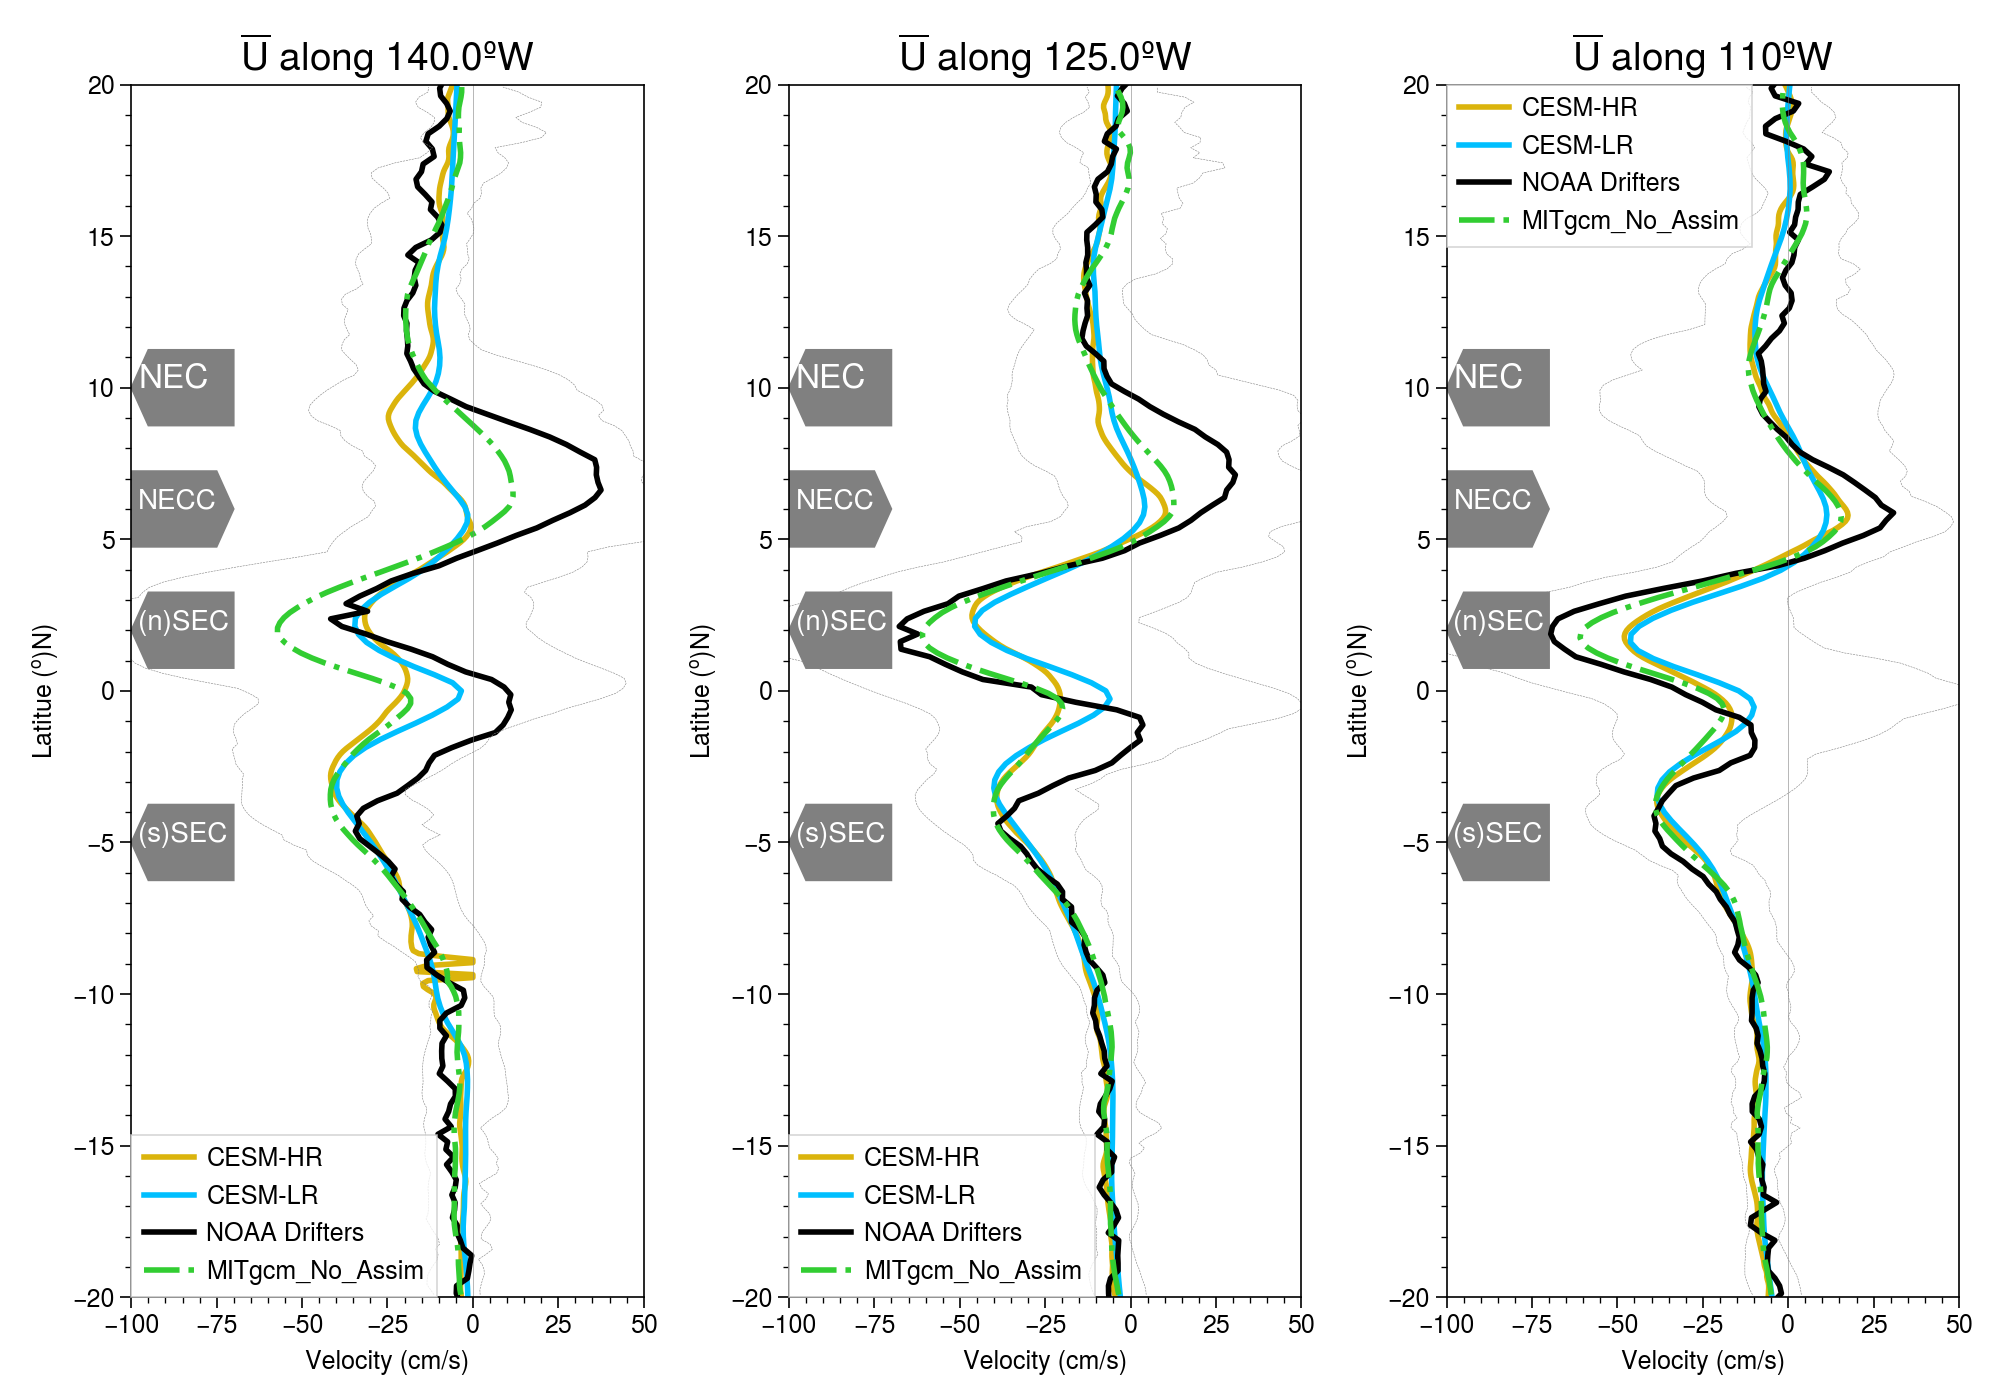

In [12]:
lon_ind=[140.0, 125.0, 110]
fig=plt.figure(figsize=(10,7),facecolor='white')

for jj in tqdm([0,1,2]):
    lon_w=lon_ind[jj]
    lat_eq=0.0
    latu_i,lonu_i=find_indices(dsu.TLONG,dsu.TLAT,360-lon_w,lat_eq)
    latl_i,lonl_i=find_indices(dsl.TLONG,dsl.TLAT,360-lon_w,lat_eq)
    lon_joh=360.00-lon_w
    U_h=dsu.UVEL.isel(nlon=lonu_i)
    U_l=dsl.UVEL.isel(nlon=lonl_i)
    U_j=dj.UM.sel(XLON=lon_joh,method='nearest')*100
    U_t=dst.UVEL.where(dst.XG==360-lon_w+0.5,drop=True).compute()
    U_d=(dd.U.where(dd.Lon==-lon_w+0.375,drop=True).squeeze()).compute()
    ax=fig.add_subplot(1, 3,jj+1)

    ax.plot(U_h.isel(z_t=0).squeeze(),dsu.ULAT[:,0],color='gold',label='CESM-HR',lw=2,)
    plt.plot(U_l.isel(z_t=0).squeeze(),dsl.ULAT[:,0],color='deepskyblue',label='CESM-LR',lw=2,)
    plt.plot(U_d*100,dd.Lat,color='black',Linewidth=2,label='NOAA Drifters')
    plt.plot(U_t.mean('time').isel(Z=0).squeeze()*100,dst.YC,color='limegreen',lw=2,linestyle='-.',label='MITgcm_No_Assim')
    plt.plot(U_t.isel(Z=0).max('time').squeeze()*100,dst.YC,color='grey',lw=0.2,linestyle='--')
    plt.plot(U_t.isel(Z=0).min('time').squeeze()*100,dst.YC,color='grey',lw=0.2,linestyle='--')
    plt.ylim(-20,20)
    plt.xlim(-100,50)
    plt.axvline(x=0,lw=0.2,color='grey')
    plt.title('$\overline{U}$ along '+str(lon_w)+'ºW',fontsize=14)
    plt.legend()
    plt.grid(b=None)
    plt.ylabel('Latitue ($^o$)N)')
    plt.xlabel('Velocity (cm/s)')

    plt.text(-98,10,'NEC',color='white',fontsize=12)
    plt.arrow(-70, 10, -30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')
    plt.text(-98,6,'NECC',color='white',fontsize=10)
    plt.arrow(-100, 6, 30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')
    plt.text(-98,2,'(n)SEC',color='white',fontsize=10)
    plt.arrow(-70, 2, -30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')
    plt.text(-98,-5,'(s)SEC',color='white',fontsize=10)
    plt.arrow(-70, -5, -30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')

fig.tight_layout()    

100%|██████████| 3/3 [00:22<00:00,  7.54s/it]


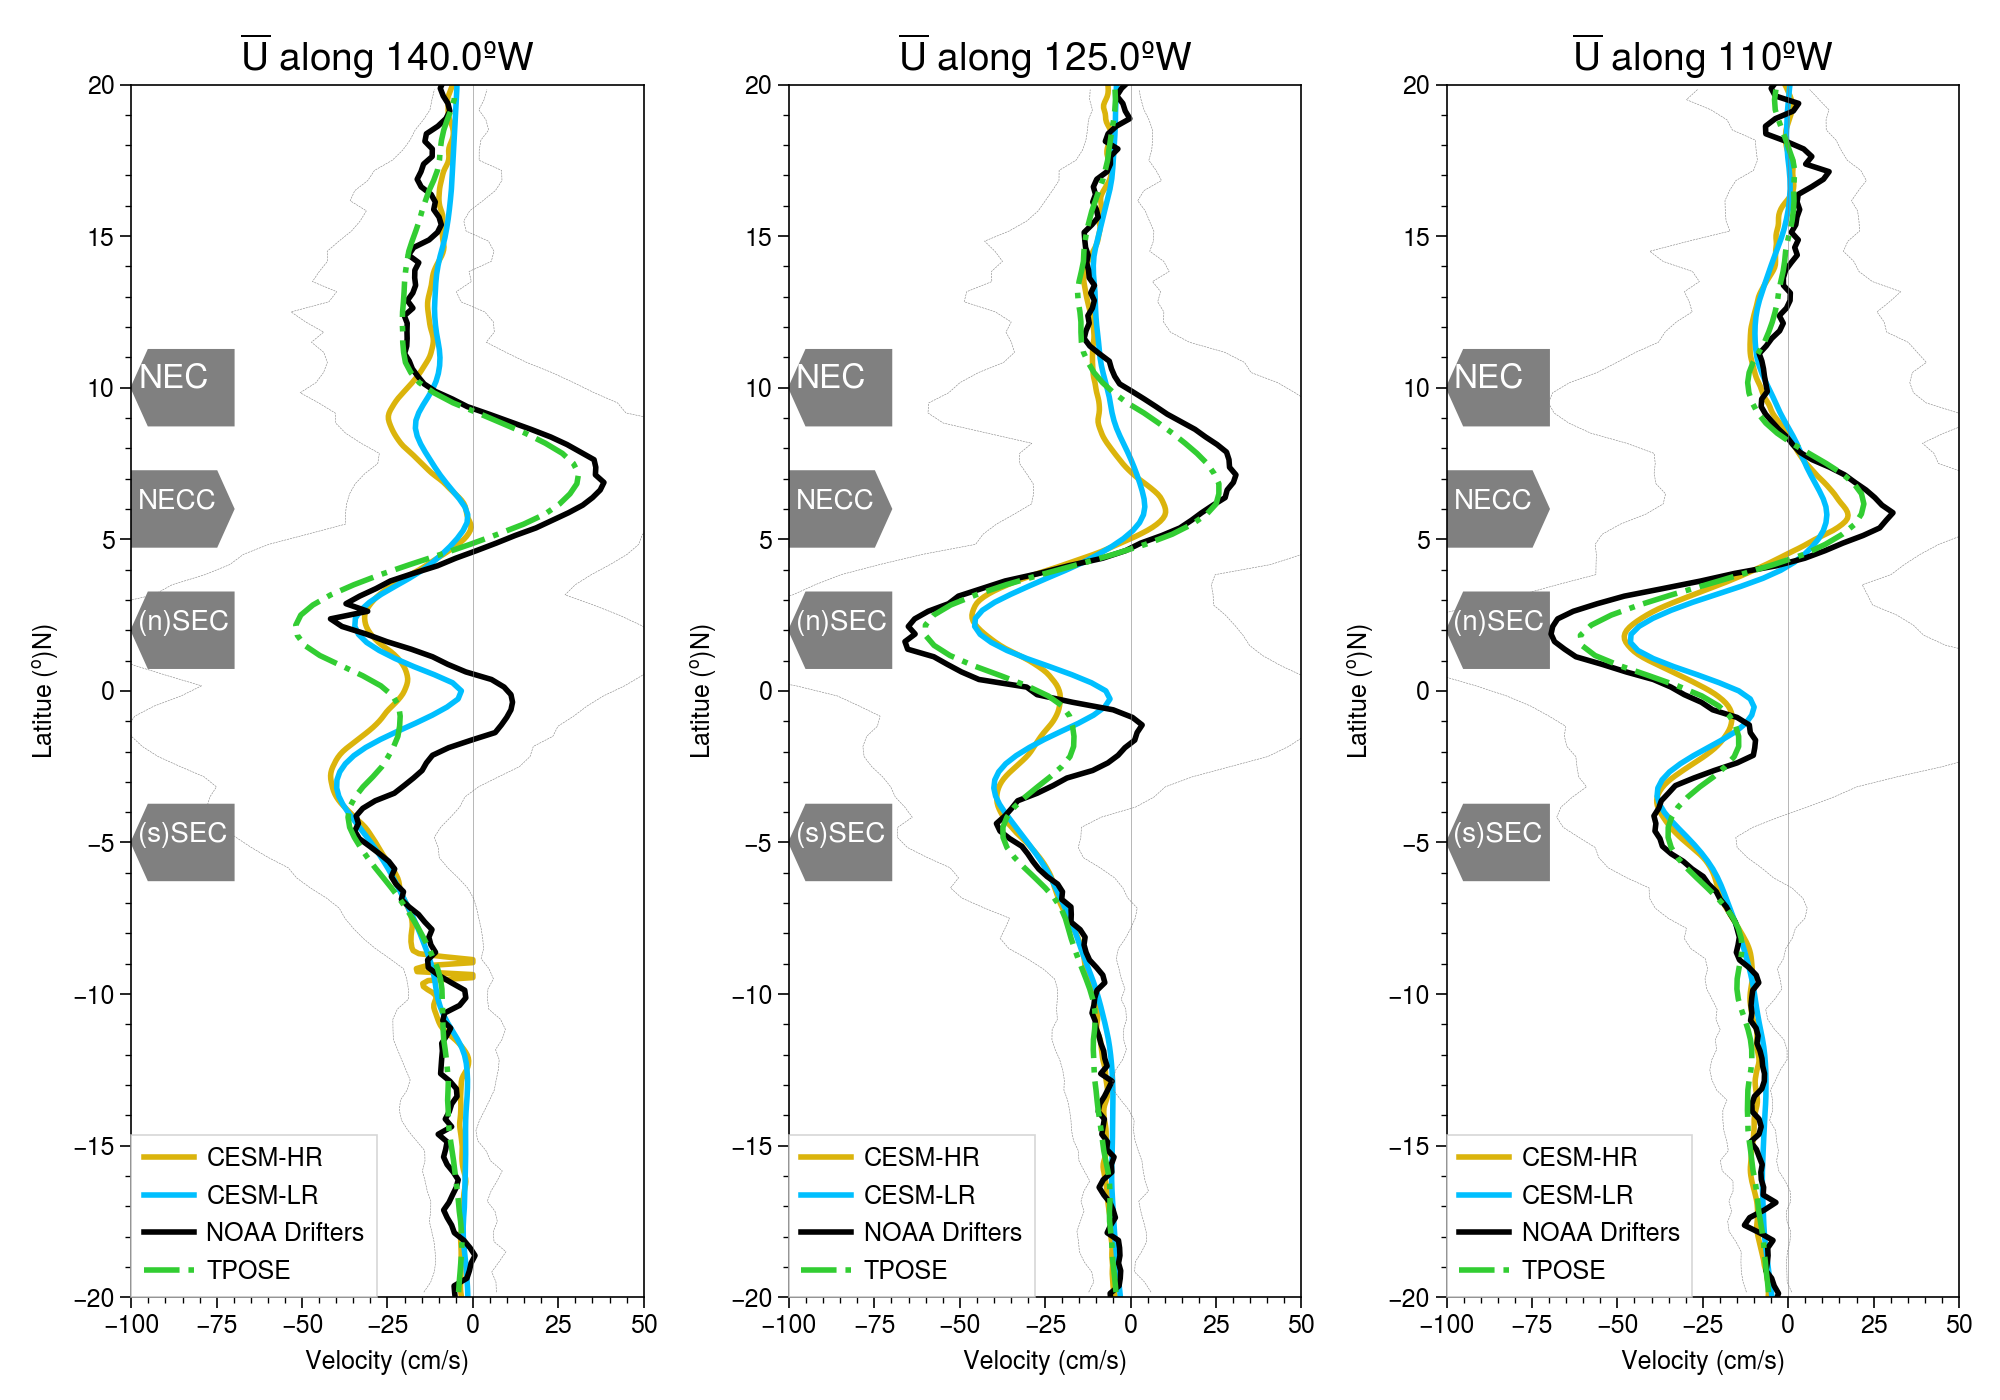

In [147]:
lon_ind=[140.0, 125.0, 110]
fig=plt.figure(figsize=(10,7),facecolor='white')

for jj in tqdm([0,1,2]):
    lon_w=lon_ind[jj]
    lat_eq=0.0
    latu_i,lonu_i=find_indices(dsu.TLONG,dsu.TLAT,360-lon_w,lat_eq)
    latl_i,lonl_i=find_indices(dsl.TLONG,dsl.TLAT,360-lon_w,lat_eq)
    lon_joh=360.00-lon_w
    U_h=dsu.UVEL.isel(nlon=lonu_i)
    U_l=dsl.UVEL.isel(nlon=lonl_i)
    U_j=dj.UM.sel(XLON=lon_joh,method='nearest')*100
    U_t=dst.UVEL.where(dst.lon==360-lon_w+0.5,drop=True).compute()
    U_d=(dd.U.where(dd.Lon==-lon_w+0.375,drop=True).squeeze()).compute()
    ax=fig.add_subplot(1, 3,jj+1)

    ax.plot(U_h.isel(z_t=0).squeeze(),dsu.ULAT[:,0],color='gold',label='CESM-HR',lw=2,)
    plt.plot(U_l.isel(z_t=0).squeeze(),dsl.ULAT[:,0],color='deepskyblue',label='CESM-LR',lw=2,)
    plt.plot(U_d*100,dd.Lat,color='black',Linewidth=2,label='NOAA Drifters')
    plt.plot(U_t.mean('iTIME').isel(iDEPTH=0).squeeze()*100,dst.lat,color='limegreen',lw=2,linestyle='-.',label='TPOSE')
    plt.plot(U_t.isel(iDEPTH=0).max('iTIME').squeeze()*100,dst.lat,color='grey',lw=0.2,linestyle='--')
    plt.plot(U_t.isel(iDEPTH=0).min('iTIME').squeeze()*100,dst.lat,color='grey',lw=0.2,linestyle='--')
    plt.ylim(-20,20)
    plt.xlim(-100,50)
    plt.axvline(x=0,lw=0.2,color='grey')
    plt.title('$\overline{U}$ along '+str(lon_w)+'ºW',fontsize=14)
    plt.legend()
    plt.grid(b=None)
    plt.ylabel('Latitue ($^o$)N)')
    plt.xlabel('Velocity (cm/s)')

    plt.text(-98,10,'NEC',color='white',fontsize=12)
    plt.arrow(-70, 10, -30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')
    plt.text(-98,6,'NECC',color='white',fontsize=10)
    plt.arrow(-100, 6, 30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')
    plt.text(-98,2,'(n)SEC',color='white',fontsize=10)
    plt.arrow(-70, 2, -30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')
    plt.text(-98,-5,'(s)SEC',color='white',fontsize=10)
    plt.arrow(-70, -5, -30 , 0, length_includes_head=True, width=2.5, head_width=2.5, head_length=5,color='grey')

fig.tight_layout()    

In [150]:
savefig(fig,'Supp_Figures/Supp_Figure_1')

# Add Depth with TAO at same Longitudes

100%|██████████| 3/3 [00:09<00:00,  3.13s/it]


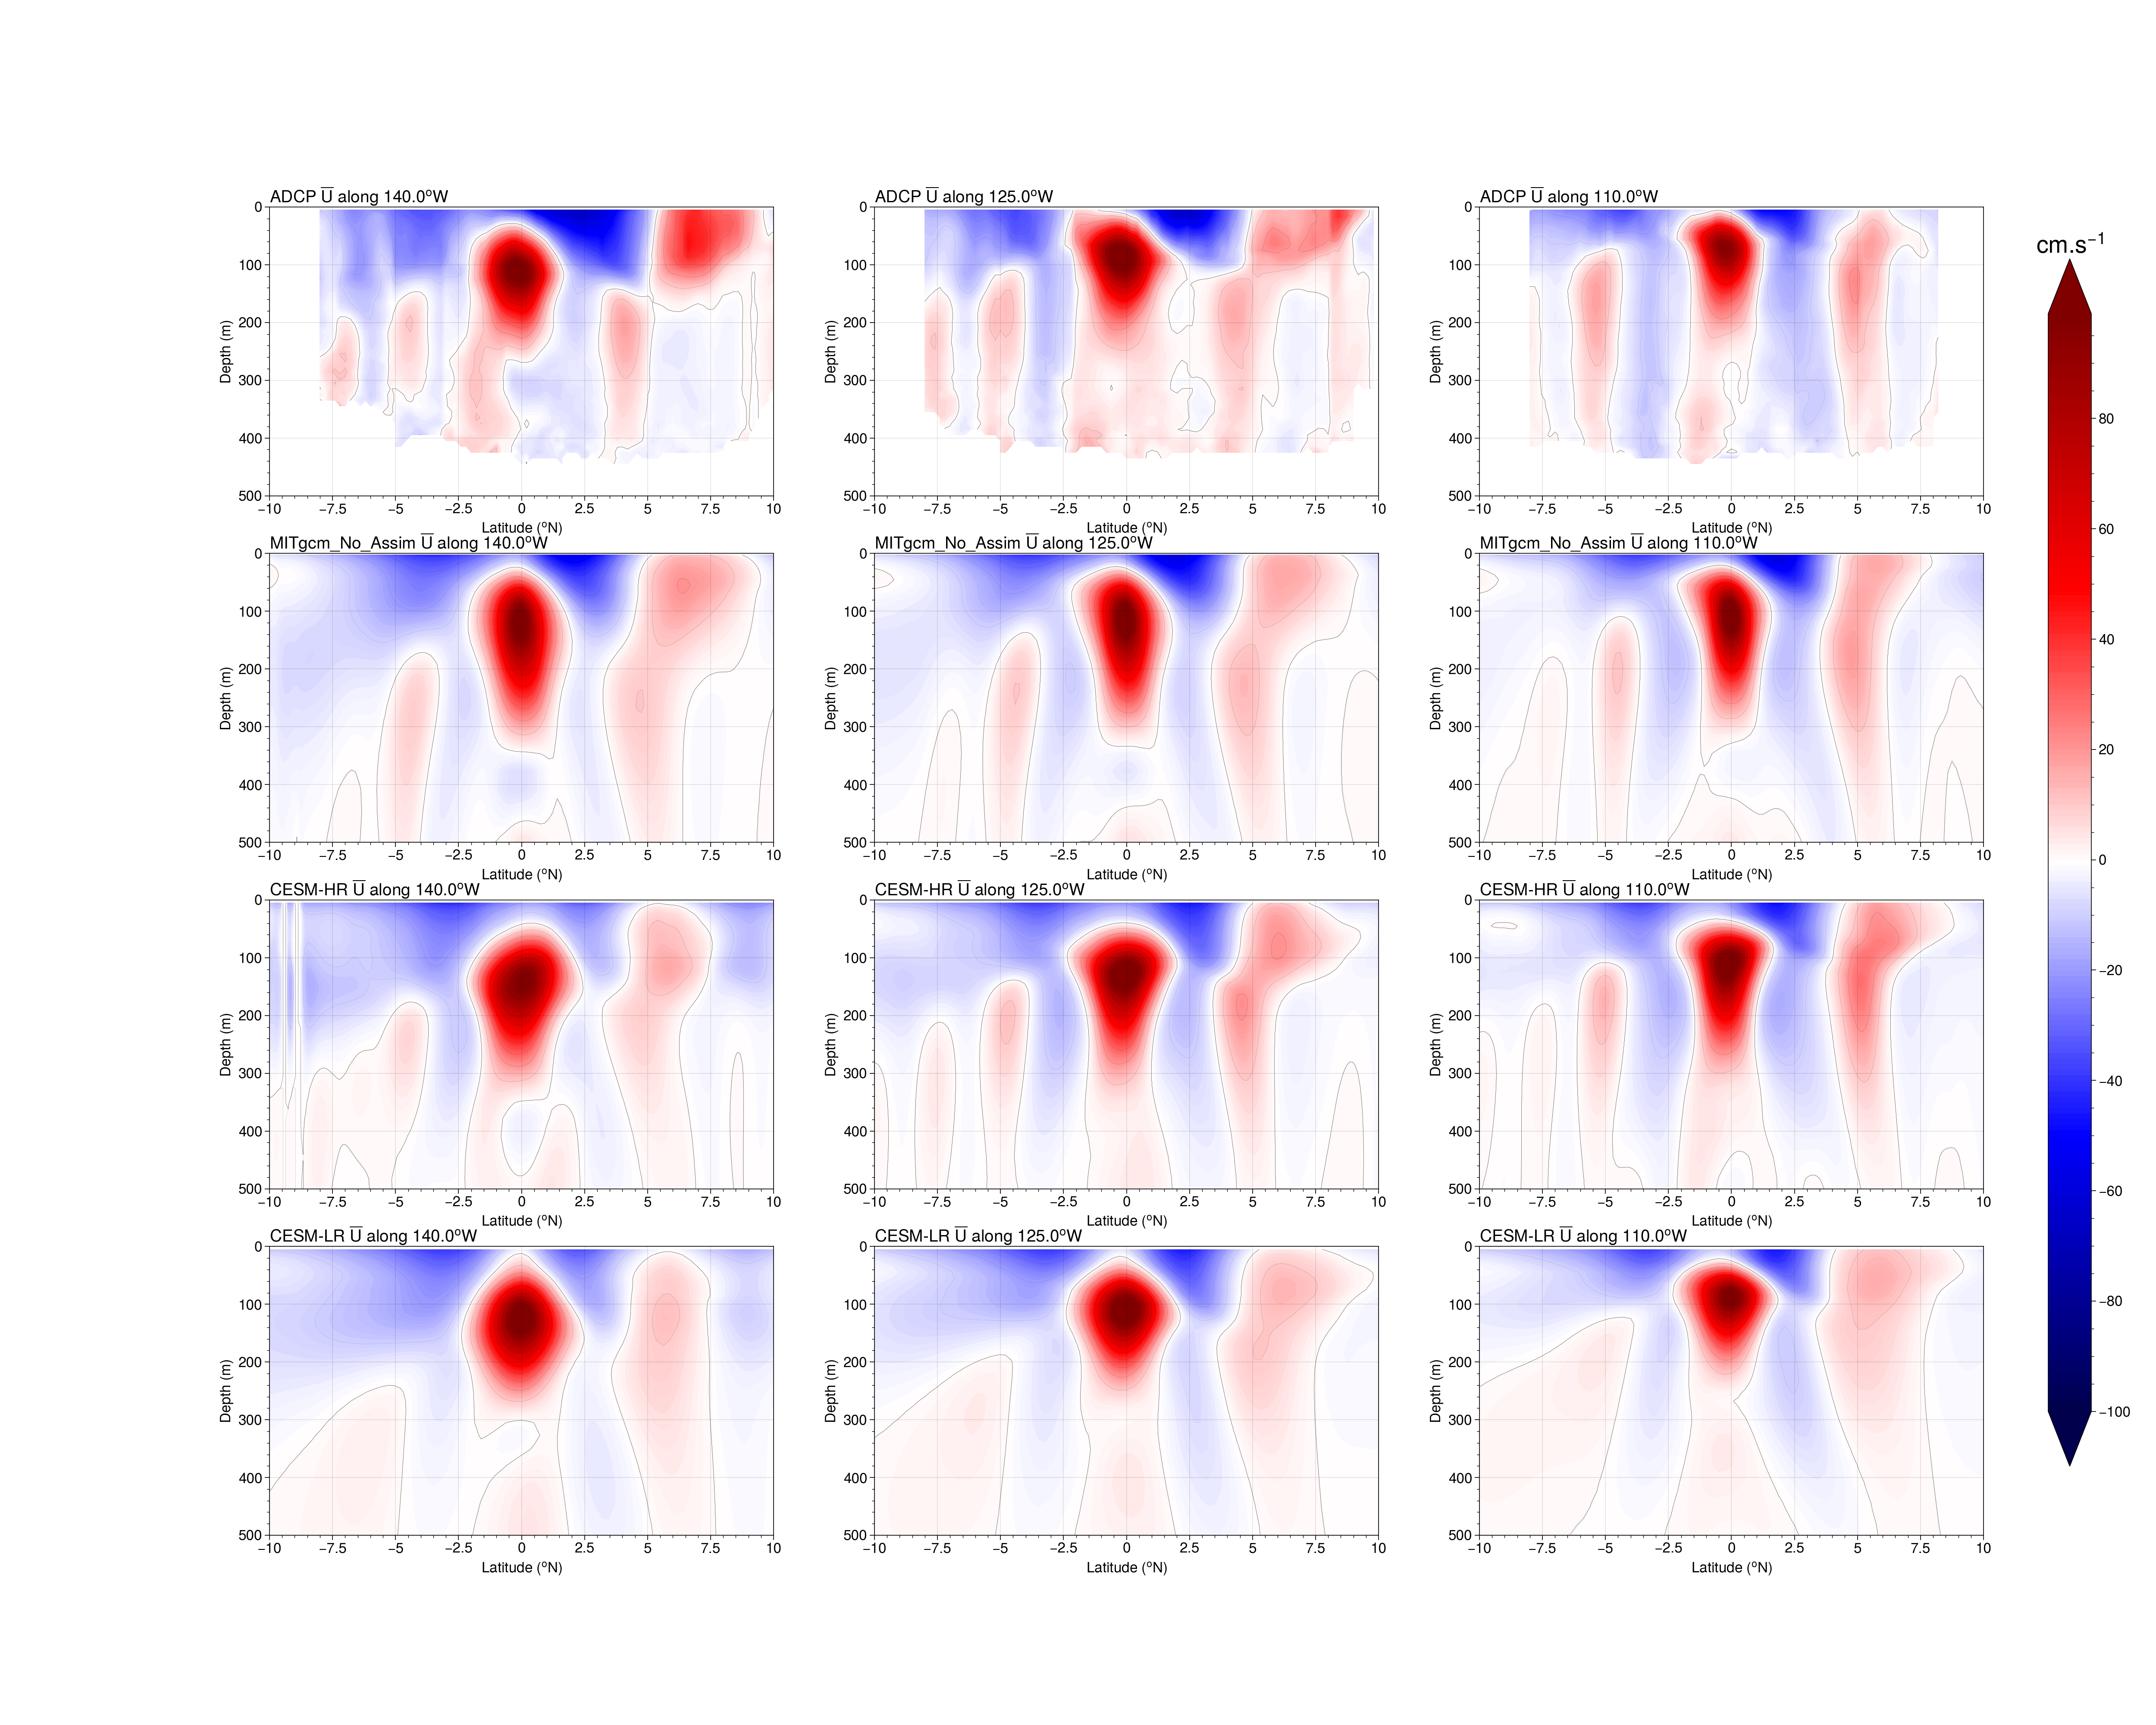

In [14]:
fig=plt.figure(figsize=(25,20),facecolor='white')
unlevels=np.arange(-100,100,1); unlevels0=np.arange(-0.01,0.01,1);unlevels1=np.arange(-100,100,10);
fs=12; fst = 14
lon_ind=[140.0, 125.0, 110.0]

for j in tqdm(np.arange(0,3)):
    lon_w=lon_ind[j]
    lat_eq=0.0
    latu_i,lonu_i=find_indices(dsu.TLONG,dsu.TLAT,360-lon_w,lat_eq)
    latl_i,lonl_i=find_indices(dsl.TLONG,dsl.TLAT,360-lon_w,lat_eq)
    lon_joh=360.00-lon_w
    lon_cars=360.00-lon_w     
    z=dsu.z_t*1e-2
    zl=dsl.z_t*1e-2
    zj=dj.ZDEP1_50
#     zt=dst.depth*(-1)
    zt=dsto.Z*(-1)
    zto=dsto.Z*(-1)
    latu=dsu.ULAT[:,lonu_i]
    latl=dsl.ULAT[:,lonl_i]
    latj=dj.YLAT11_101
#     latt=dst.lat
    latt=dsto.YC
    latto=dsto.YC

    U_h=dsu.UVEL.isel(nlon=lonu_i)
    U_l=dsl.UVEL.isel(nlon=lonl_i)
    U_j=dj.UM.sel(XLON=lon_joh,method='nearest')*100
    U_t=dst.UVEL.where(dst.XG==360-lon_w+0.5,drop=True).mean('time').compute()*100
    U_d=(dd.U.where(dd.Lon==-lon_w+0.375,drop=True).squeeze()).compute()

    varp=[U_j,U_t,U_h,U_l]
    latp=[latj,latt,latu,latl]
    zp=[zj,zt,z,zl]
    titlep=['ADCP','MITgcm_No_Assim','CESM-HR','CESM-LR']

    for k in tqdm(np.arange(0,4)):
        ax2 = plt.subplot(4,3,1+k*3+j)
        cs= ax2.contourf(latp[k],zp[k],varp[k].squeeze(),cmap='seismic',linewidths=0.1,levels=unlevels,extend='both')
        cs0= ax2.contour(latp[k], zp[k],varp[k].squeeze(), colors='black', linewidths=0.05, levels=unlevels1)
        cs0= ax2.contour(latp[k], zp[k],varp[k].squeeze(), colors='black', linewidths=0.2, levels=unlevels0)
        ax2.set_ylim([500., 0.])
        ax2.set_xlim([-10, 10])
        ax2.minorticks_on()
        ax2.set_ylabel('Depth (m)',fontsize=fs)
        ax2.set_title( titlep[k]+' $\overline{U}$ along ' +str(np.round(lon_w,2))+'$^o$W',pad=0.01,fontsize=fst, loc='left');
        ax2.tick_params(axis='both', labelsize=fs)
#         plt.text(-0.5, 100, 'EUC', {'color': 'cyan', 'fontsize': fs})
#         plt.text(-5, 50, 'SEC', {'color': 'cyan', 'fontsize': fs})
#         plt.text(2, 50, 'SEC', {'color': 'cyan', 'fontsize': fs})
#         plt.text(-6, 200+10, 'SSCC', {'color': 'cyan', 'fontsize': fs})
#         plt.text(3.5, 200+10, 'NSCC', {'color': 'cyan', 'fontsize': fs})
#         plt.text(5, 50, 'NECC', {'color': 'cyan', 'fontsize': fs})
#         plt.text(9, 50, 'NEC', {'color': 'cyan', 'fontsize': fs})
        ax2.set_xlabel('Latitude ($^o$N)', fontsize=fs)
        ax2.xaxis.set_ticks_position('bottom')

# fig.subplots_adjust(right=0.84)
# cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cs, cax=cbar_ax,)
cbar.ax.set_title('cm.s$^{-1}$',fontsize=20);
cbar.ax.tick_params(labelsize=12)

### Calculate speed as:  
$u=\sqrt{(U^2+V^2)}$